Optimization of FOPDT model parameters based in the model for vehicle velocity.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Imports and helpers

In [3]:
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
from scipy import constants
from scipy import optimize as opt

In [4]:
def eval_model(model, xs):
    return np.array(list(map(model, xs)))

## Mathematical model

$\frac{dv(t)}{dt} = \frac{1}{m} [ F_p u(t) - \frac{1}{2} \rho A C_d v(t)^2 ] - g sin(\theta)$

In [5]:
# Mass (car + load), kg
m = 700

# Thrust parameter, (N / %pedal)
F_p = 30

# Air density, kg/m^3
rho = 1.225 

# vehicle cross-sectional area (m^2)
A = 5

# Drag coefficient
C_d = 0.24

def vehicle_model(v, t, u_func, theta_func):
    
    u = u_func(t)
    theta = theta_func(t)
        
    drive = F_p * u
    drag = 0.5 * rho * A * C_d * (v**2)
    slope = constants.g * np.sin(theta)
    
    return (1. / m) * (drive - drag) - slope
    

## Simulation of the original model

In [6]:
t = np.linspace(0, 200, 100)

In [7]:
step_t = 25
step_val = 50

# input function
def step_input(t):
    return 0 if t < step_t else step_val

# disturbance function
def no_slope(t):
    return 0

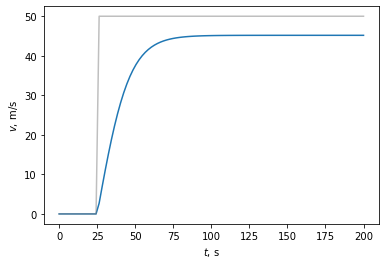

In [8]:
initial = 0

v_sim = odeint(vehicle_model, initial, t, args=(step_input, no_slope))

plt.plot(t, v_sim)
plt.plot(t, eval_model(step_input, t), color='gray', alpha=0.5)

plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()

## Optimization of FOPDT model parameters

$\tau \frac{dy(t)}{dt} = -y(t) + K u(t - \theta) $

In [9]:
def create_fopdt(K, tau, theta, u_func):
    
    def model(y, t):
        
        u = u_func(t - theta)
        
        return (1. / tau) * (-y + K * u)
    
    return model

In [10]:
# globals: t, v_sim

def fopdt_cost(params):
    
    gain, time_const, delay = params
    
    fopdt_model = create_fopdt(gain, time_const, delay, u_func=step_input)

    fopdt_sim = odeint(fopdt_model, 0, t)
    
    rms = np.sum(np.square(v_sim - fopdt_sim))
    return rms

In [11]:
# testing the output of the cost function
fopdt_cost([0.9, 14., 0.5])

37.8222551493863

Optimization with `scipy.optimize`

In [12]:
opt_res = opt.minimize(fopdt_cost, x0=[1., 10., 0.5], bounds=[(0.5, 1.5), (5., 15.), (0, 1.)], method='SLSQP')

opt_res

     fun: 19.632776465945764
     jac: array([ 1.91986561e-02,  8.65650177e-03, -9.99528289e+00])
 message: 'Optimization terminated successfully'
    nfev: 76
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([ 0.90727137, 14.33811766,  0.87604393])

Visualization of the optimized model

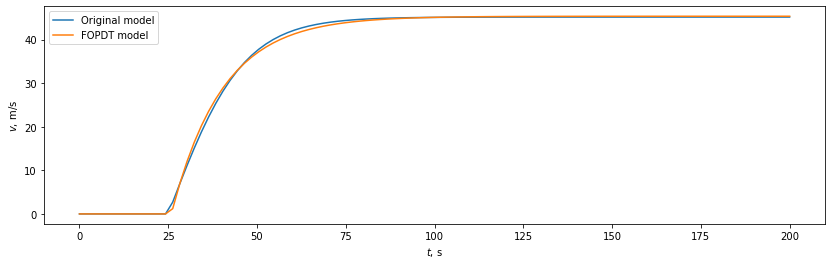

In [13]:
gain, time_const, delay = opt_res.x 

fopdt_model = create_fopdt(gain, time_const, delay, u_func=step_input)

fopdt_sim = odeint(fopdt_model, 0, t)

plt.figure(figsize=(14, 4))
plt.plot(t, v_sim, label='Original model')
plt.plot(t, fopdt_sim, label='FOPDT model')
plt.legend()
plt.xlabel('$t$, s')
plt.ylabel('$v$, m/s')
plt.show()